In [174]:
import pandas as pd
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.dates as mdates
import os
import re
from scipy import stats
import numpy as np

In [44]:
class OffsetYearLocator(mdates.YearLocator):
    def __init__(self, *args, **kwargs):
        self.offset = kwargs.pop("offset", 0)
        mdates.YearLocator.__init__(self, *args, **kwargs)

    def tick_values(self, vmin, vmax):
        ymin = self.base.le(vmin.year) * self.base.step - self.offset
        ymax = self.base.ge(vmax.year) * self.base.step + (self.base.step -
                                                           self.offset)
        ticks = [vmin.replace(year=ymin, **self.replaced)]
        while True:
            dt = ticks[-1]
            if dt.year >= ymax:
                return mdates.date2num(ticks)
            year = dt.year + self.base.step
            ticks.append(dt.replace(year=year, **self.replaced))


def formatar_eixo_tempo(ax, year_interval=10, month_interval=1, day_interval=1,
                        year_interval_minor=1, month_interval_minor=1, day_interval_minor=1
                        , minor_offset=1):

    years = mdates.YearLocator(year_interval, month=month_interval, day=day_interval)

    years_minor = OffsetYearLocator(year_interval_minor, month=month_interval_minor,
                                    day=day_interval_minor,
                                    offset=minor_offset)

    dfmt = mdates.DateFormatter('%Y')
    dfmt_minor = mdates.DateFormatter('%y')

    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_minor_locator(years_minor)
    ax.xaxis.set_major_formatter(dfmt)
    ax.xaxis.set_minor_formatter(dfmt_minor)
    ax.get_xaxis().set_tick_params(which='major', pad=15)

    plt.setp(ax.get_xmajorticklabels(), rotation=0, weight="bold", ha="center")

In [173]:
def decomposicao_temporal(df, latitude, periodo):
    if periodo == 'serie' or periodo == 'série':
        periodo = "Série histórica"
        res = STL(df, period=12).fit()
    elif periodo == 'úmido' or periodo == 'umido':
        periodo = "Período úmido (Outubro a Março)"
        res = STL(df, period=6, seasonal=7, seasonal_jump=7).fit() #checar com o eric amanhã o seasonal e seasonal_jump
    
    fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(16,8))
    if latitude == "-10_-17.5":
        regiao = "Bloqueio Norte"
    elif latitude == "-17.5_-25":
        regiao = "Bloqueio Sul"
    elif latitude == "-10_-25":
        regiao = "Área total"
    fig.suptitle("Índice de bloqueio (" + periodo + ": " + regiao + ")")
    
    
    ax[0].plot(pd.to_datetime(res.observed.index), res.observed.values)
    #formatar_eixo_tempo(ax[0])
    ax[1].plot(pd.to_datetime(res.trend.index), res.trend.values)
    ax[2].plot(pd.to_datetime(res.seasonal.index), res.seasonal.values)
    ax[3].plot(pd.to_datetime(res.resid.index), res.resid.values)
    formatar_eixo_tempo(ax[3])
    
    plt.savefig("d_indice_" + regiao + "_" + periodo + ".png")

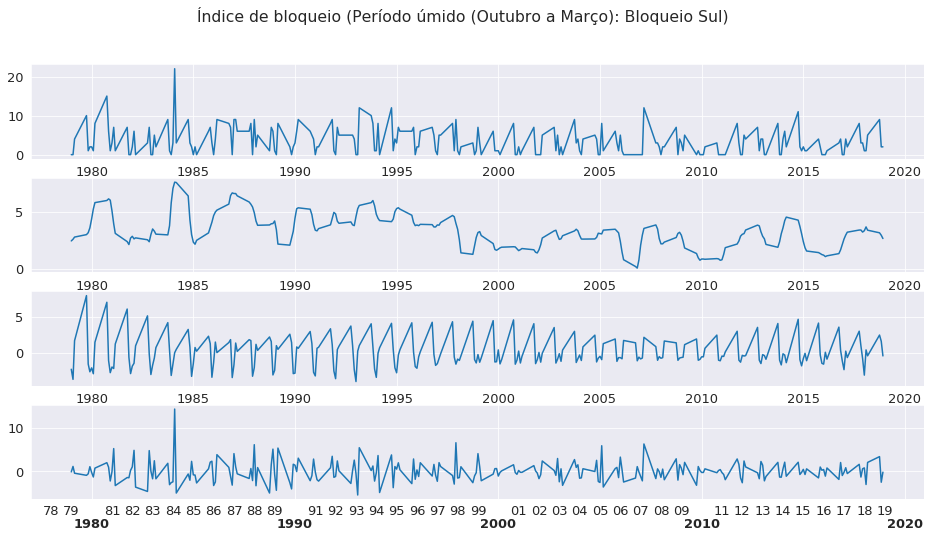

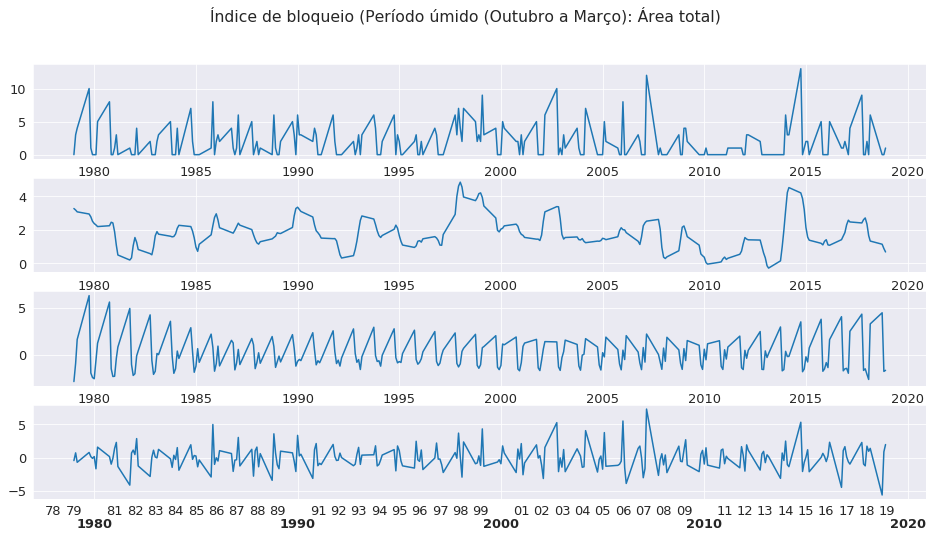

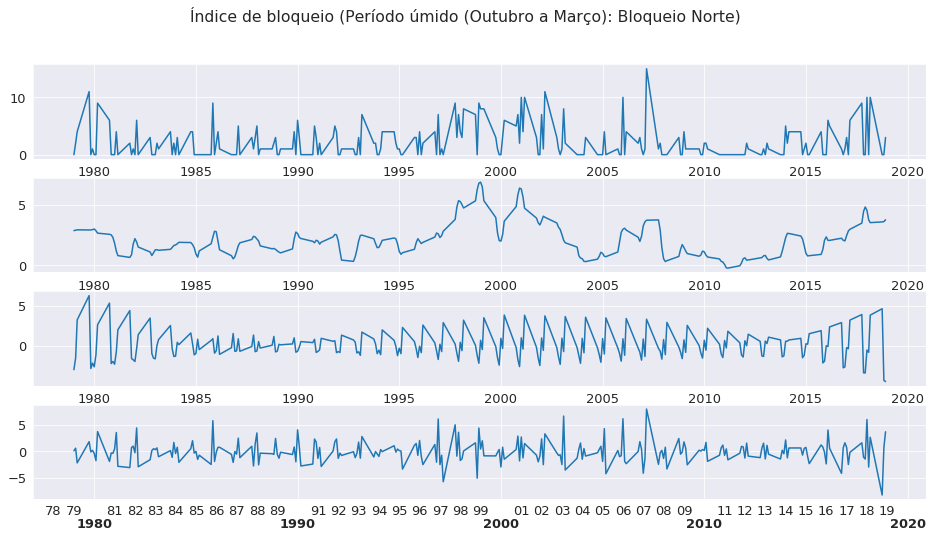

In [176]:
pattern = 'úmido'
for arquivo in os.listdir():
    try:
        match = re.search(pattern, arquivo).group(0)
        if match:
            df = pd.read_csv(arquivo, header = 0, index_col=0)
            m = re.search('úmido_(.+?).csv', arquivo)
            if m:
                latitude = m.group(1)
            decomposicao_temporal(df, latitude, pattern)
    except:
        pass

In [354]:
def corrplot(file, latitude, mes, periodo):
    df = pd.read_csv(file, header = 0, index_col=0)
    df.rename(columns={"246": "Porto Primavera","34":"Ilha Solteira", "237":"Barra Bonita", "240":"Promissão", 
                       "33":"São Simão", "24":"Emborcação", "6": "Furnas", "18":"Água Vermelha", "156":"Três Marias",
                       "168": "Sobradinho Inc", "275":"Tucuruí", "287":"Santo Antônio", "285":"Jirau", "190":"Boa Esperança",
                       "254":"Pedra do Cavalo", "111":"Passo Real", "217":"Machadinho", "74":"Foz do Areia", "78":"Salto Osório",
                       "66": "Itaipu", "63":"Rosana", "61":"Capivara"}, 
                     inplace=True)

    ixcorrs = {}
    d850corrs = {}
    v850corrs = {}
    v500corrs = {}

    for column in df.columns:
        if stats.pearsonr(df[column], df['índice de bloqueios'])[1] < 0.05:
            ixcorrs.update({column: stats.pearsonr(df[column], df['índice de bloqueios'])[0]})
        if stats.pearsonr(df[column], df['vort (850 hPa)'])[1] < 0.05:
            v850corrs.update({column: stats.pearsonr(df[column], df['vort (850 hPa)'])[0]})
        if stats.pearsonr(df[column], df['div (850 hPa)'])[1] < 0.05:
            d850corrs.update({column: stats.pearsonr(df[column], df['div (850 hPa)'])[0]})
        if stats.pearsonr(df[column], df['vort (500 hPa)'])[1] < 0.05:
            v500corrs.update({column: stats.pearsonr(df[column], df['vort (500 hPa)'])[0]})

    df_1 = pd.DataFrame.from_dict(ixcorrs, orient='index', columns=['Índice de bloqueios (850 hPa)'])
    df_2 = pd.DataFrame.from_dict(v850corrs, orient='index', columns=['Persistência de vorticidade (850 hPa)'])
    df_3 = pd.DataFrame.from_dict(d850corrs, orient='index', columns = ['Persistência de divergência (850 hPa)'])
    df_4 = pd.DataFrame.from_dict(v500corrs, orient='index', columns = ['Persistência de vorticidade (500 hPa)'])


    df_total = pd.concat([df_1, df_2, df_3, df_4], axis=1)
    corr = df_total.T
    corr.drop(['div (850 hPa)', 'índice de bloqueios', 'vort (500 hPa)', 'vort (850 hPa)'], axis=1, inplace=True)
    if latitude == '-10.0 : -25.0':
        regiao = 'Área total'
    elif latitude == '-10.0 : -17.5':
        regiao = 'Bloqueio norte'
    elif latitude == '-17.5 : -25.0':
        regiao = 'Bloqueio sul'
    fig, ax = plt.subplots(figsize=(16,8))
    ax = sns.heatmap(corr, annot=True, linewidths=0.5, linecolor='white', cmap= sns.diverging_palette(20, 220, n=256), annot_kws={"size": 13}, vmin=-1, vmax=1, center = 0)
    ax.set_title('Bloqueios (' + regiao + ': ' + periodo + ' (' + mes + '))')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=15,
             rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), fontsize=15)

    fig.tight_layout()
    plt.savefig('corrBloqueios (' + regiao + ': ' + periodo + ' (' + mes + ')).png', format='png')
    
    #ax.imshow(corr, cmap = "RdBu")
    #plt.xticks(range(len(corr.columns)), corr.columns, fontsize=14);
    #plt.yticks(range(len(corr.index)), corr.index, fontsize=14);
    #ax.xaxis.set_ticks_position('bottom')
    #ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    #im = ax.imshow(corr)
    # We want to show all ticks...
    #ax.set_xticks(np.arange(len(corr.columns)))
    #ax.set_yticks(np.arange(len(corr.index)))
    # ... and label them with the respective list entries
    #ax.set_xticklabels(corr.columns)
    #ax.set_yticklabels(corr.index)
    #for i in range(len(corr.columns)):
    #    for j in range(len(corr.index)):
    #        text = ax.text(j, i, corr[i, j],
    #                       ha="center", va="center", color="w")


<ipython-input-354-56059d434863>:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(16,8))


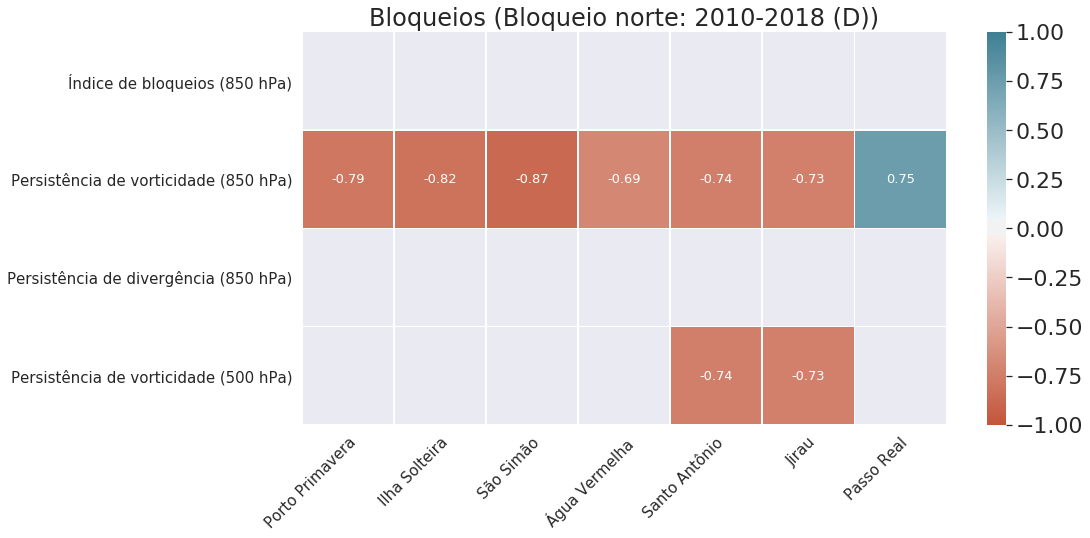

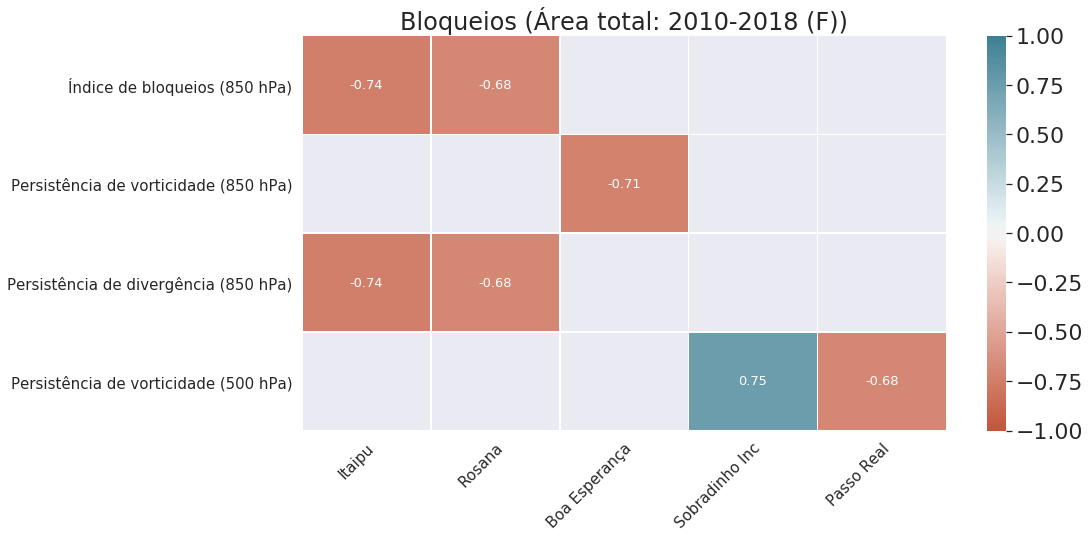

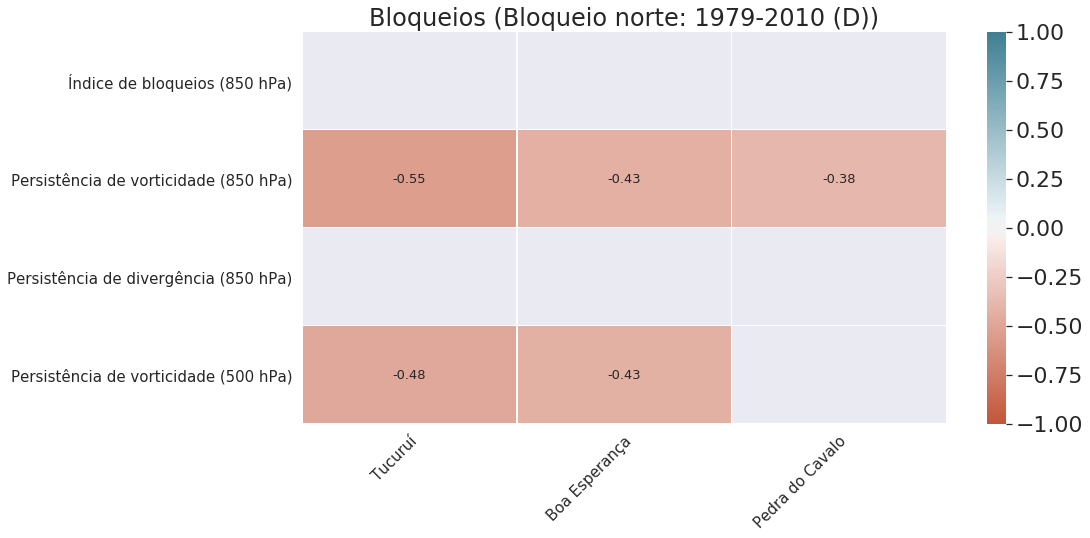

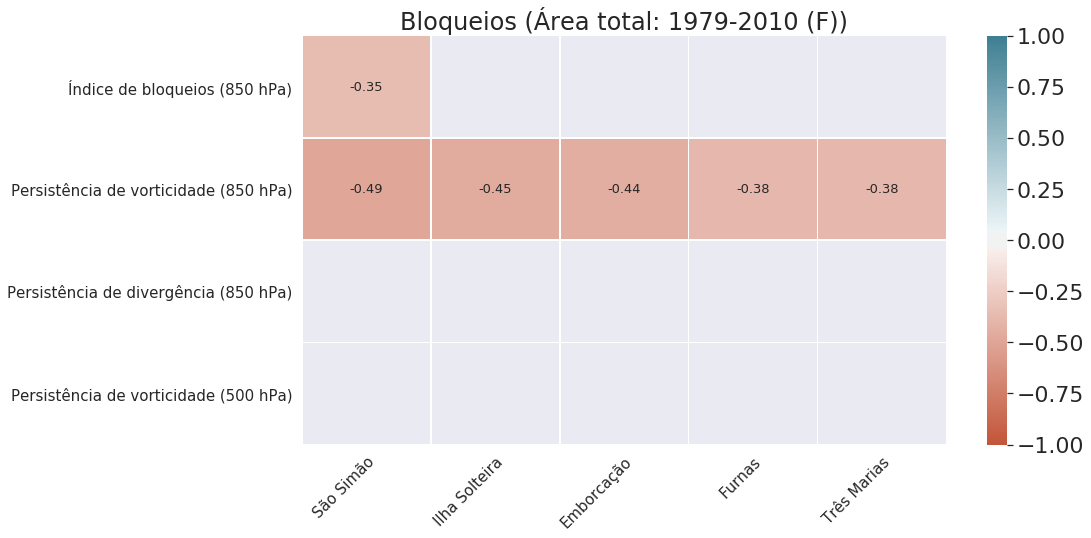

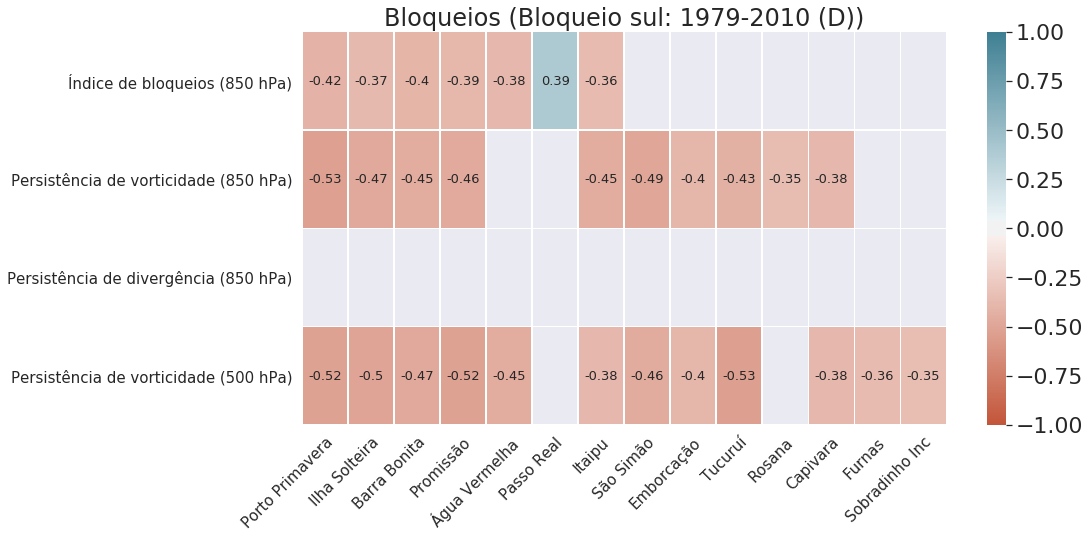

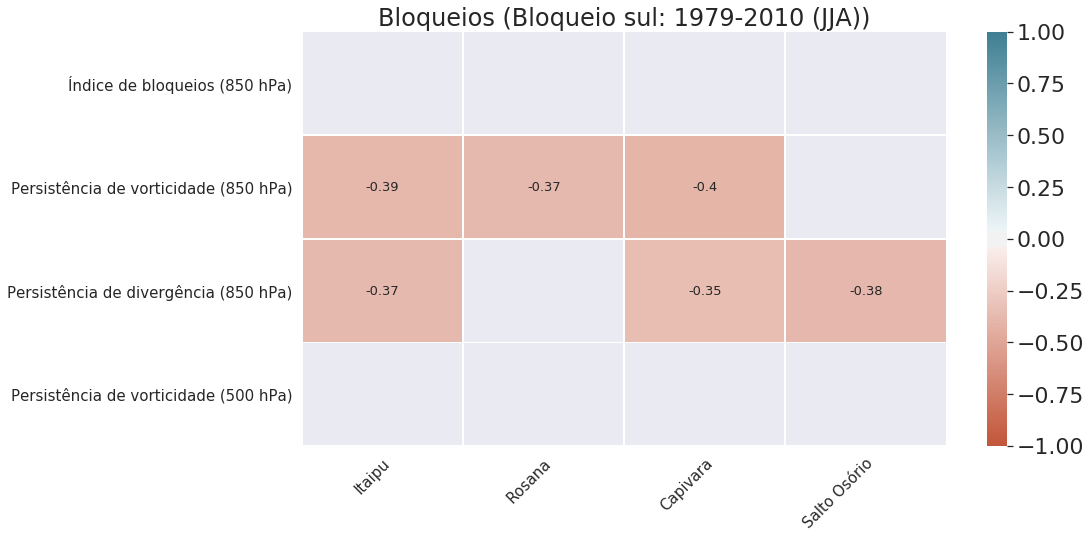

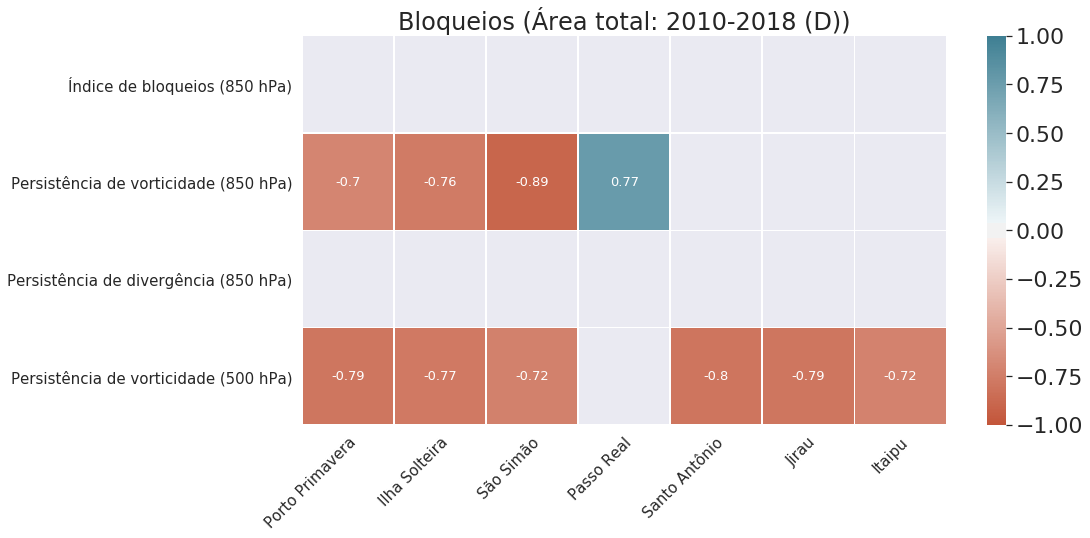

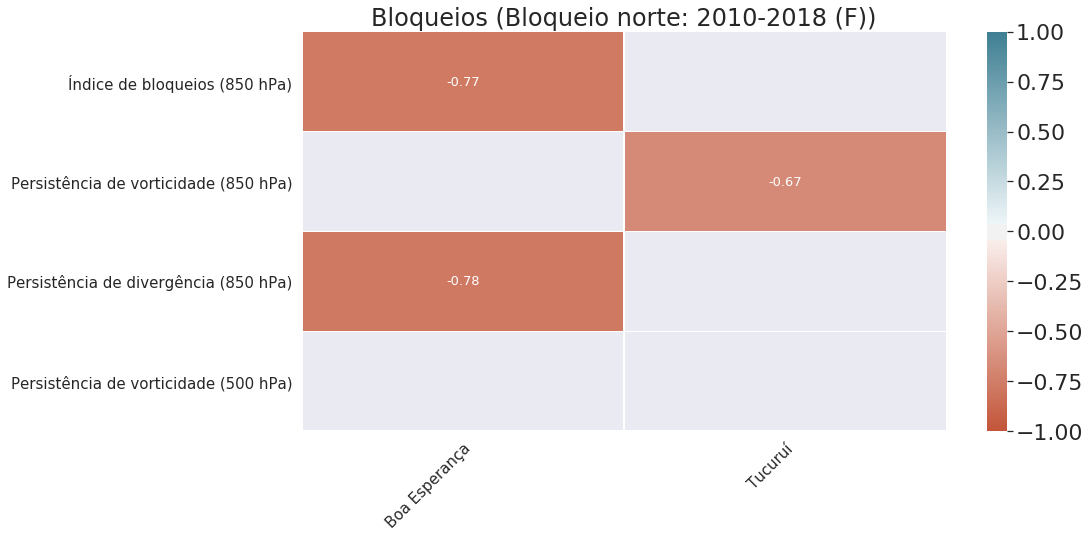

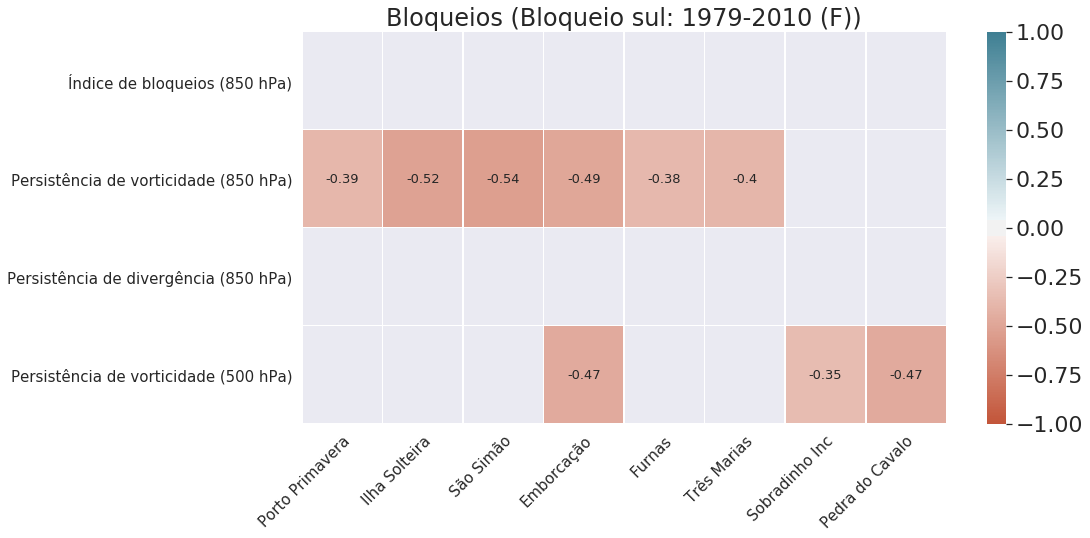

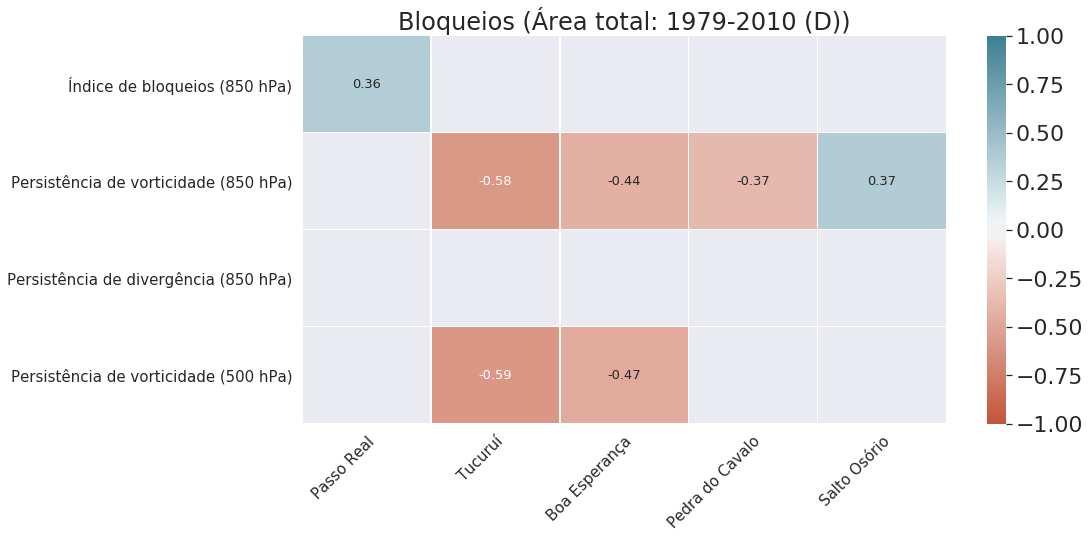

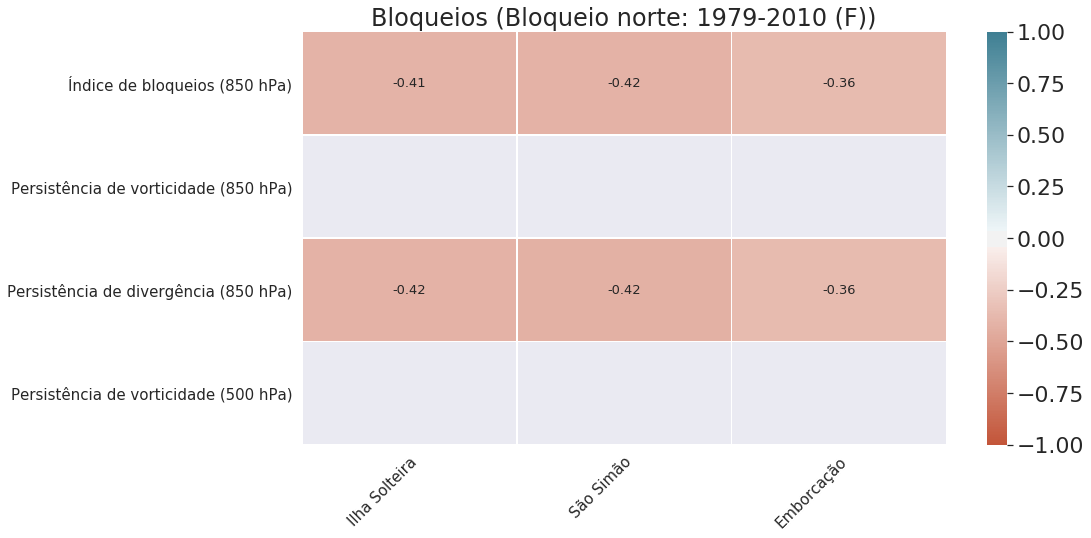

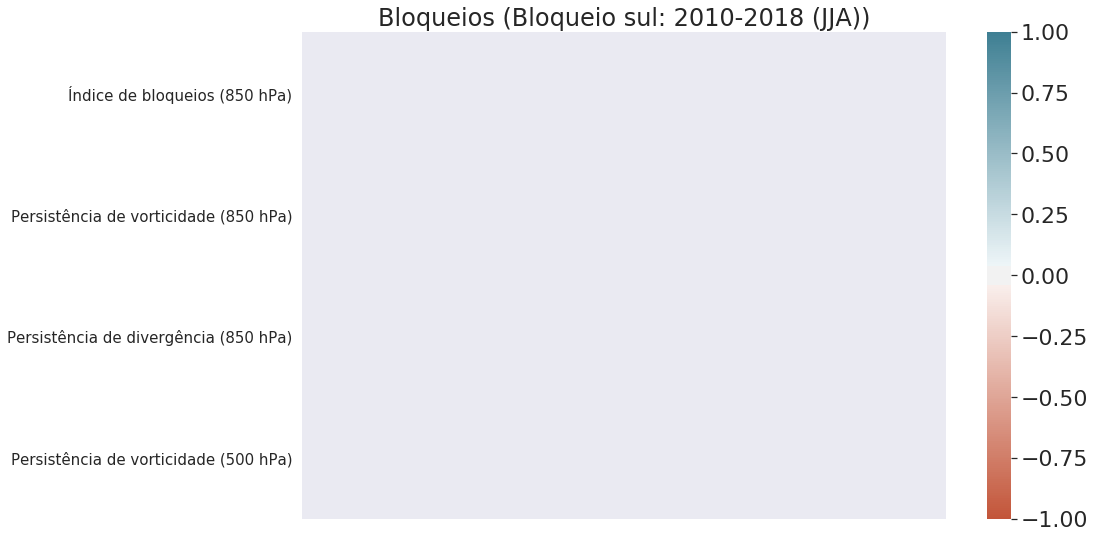

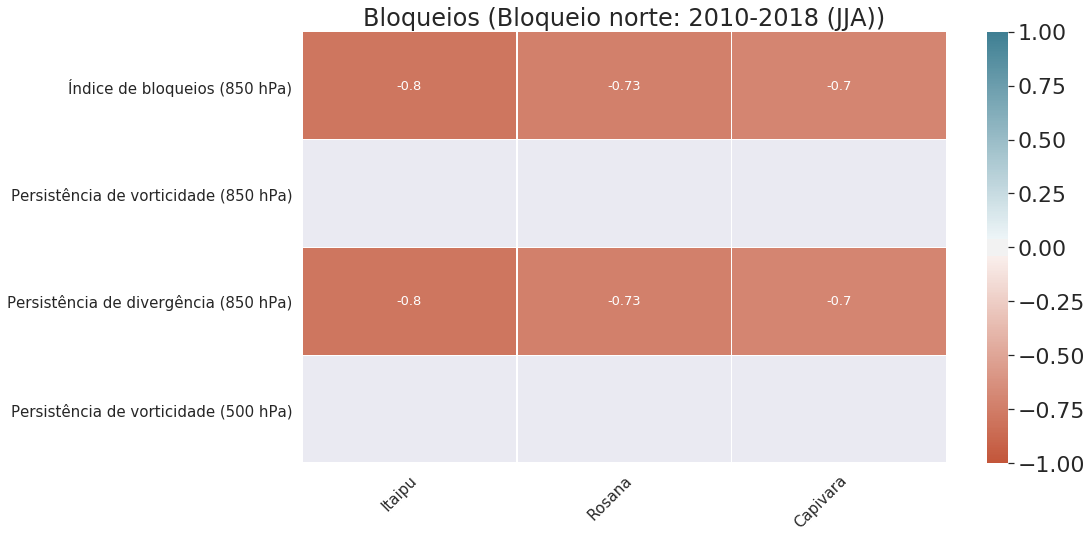

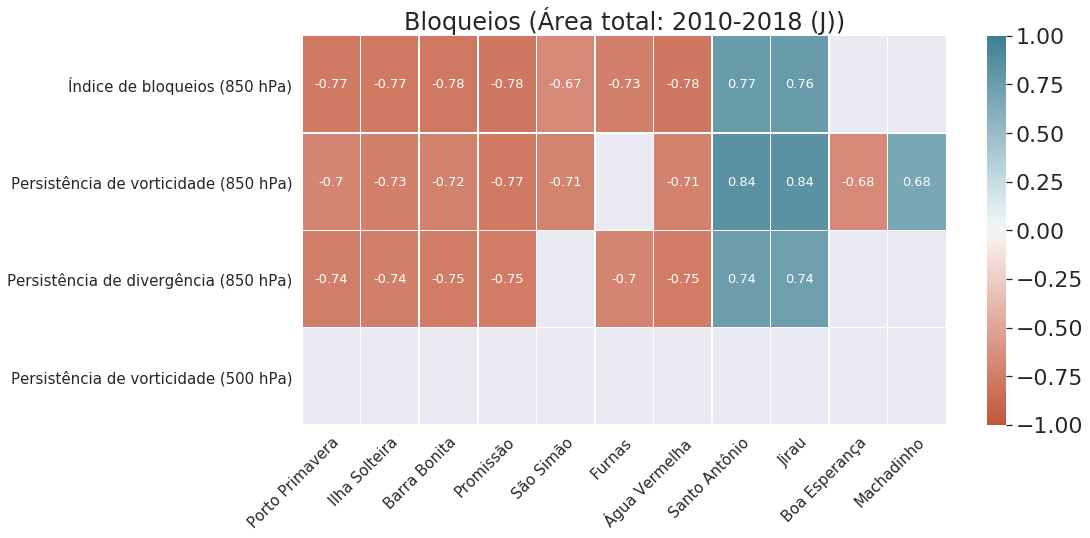

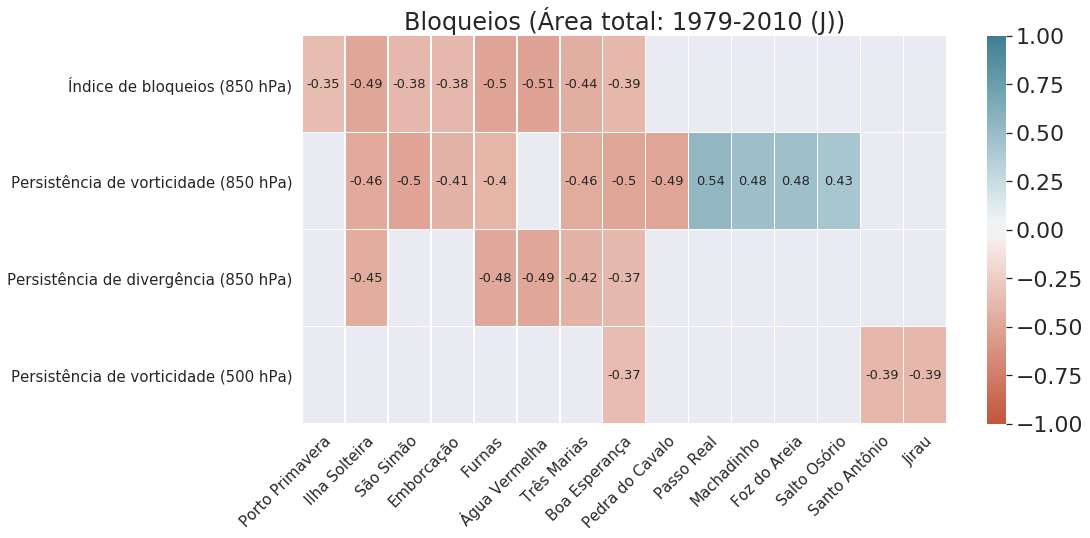

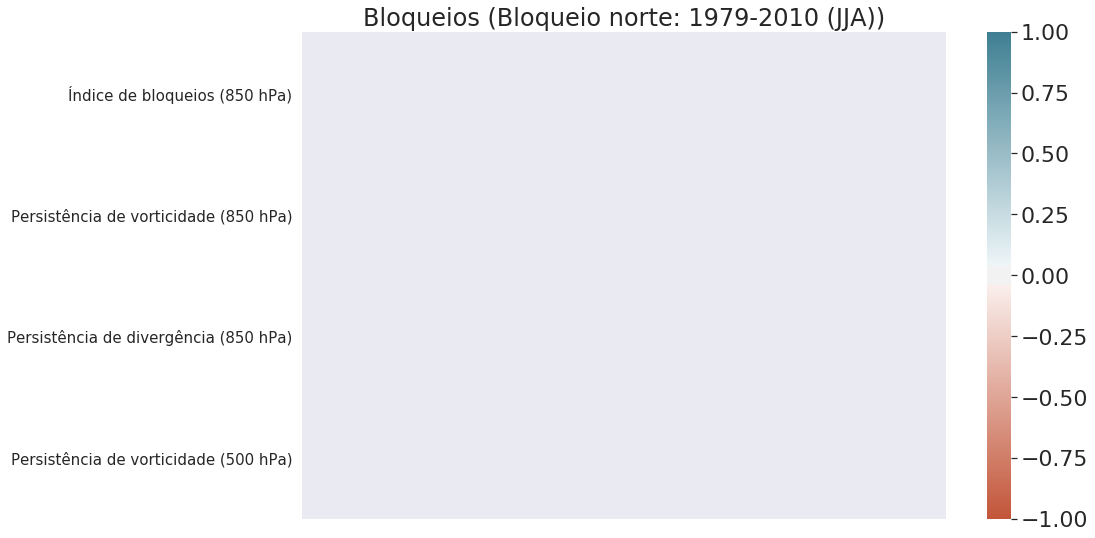

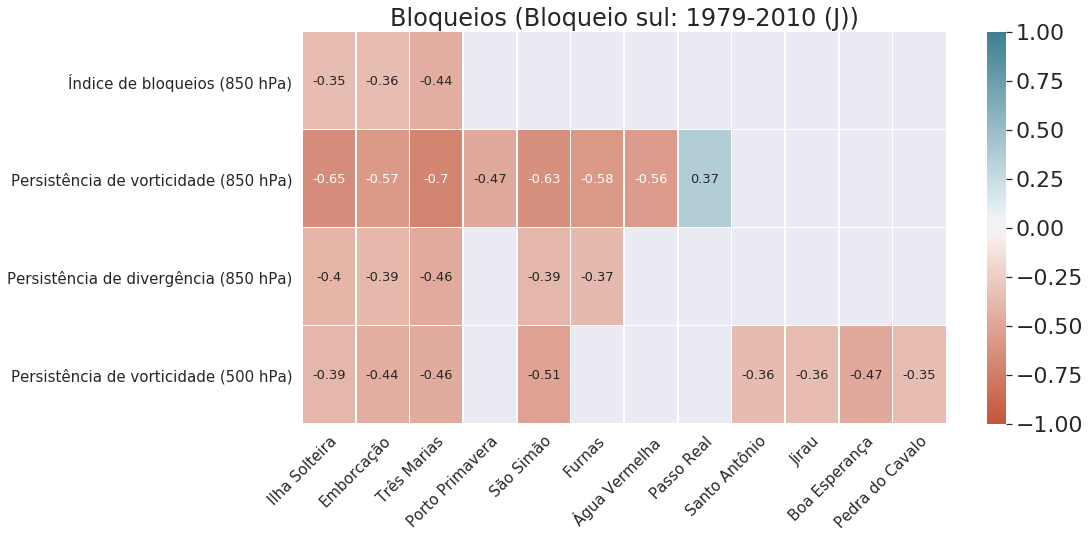

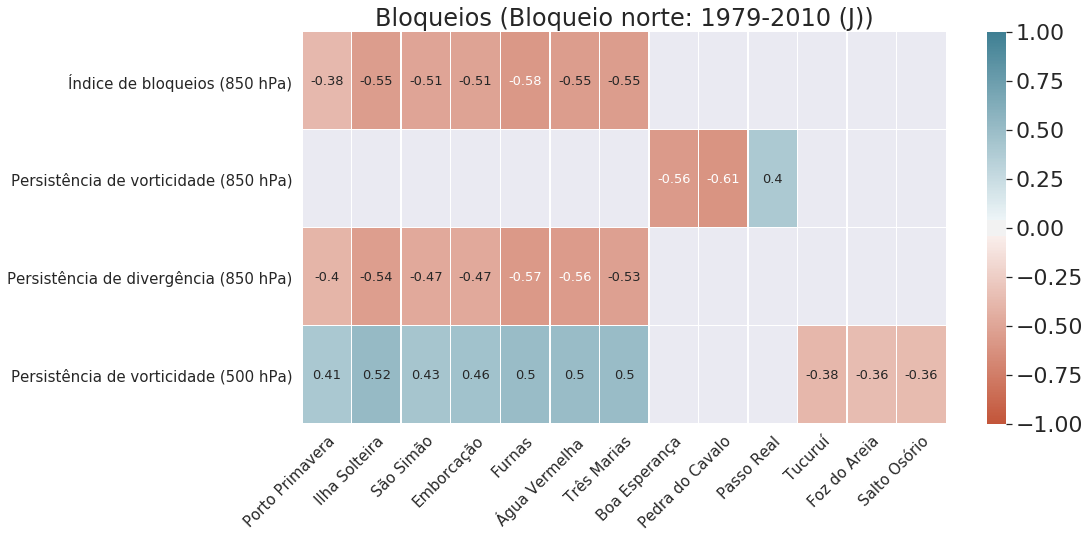

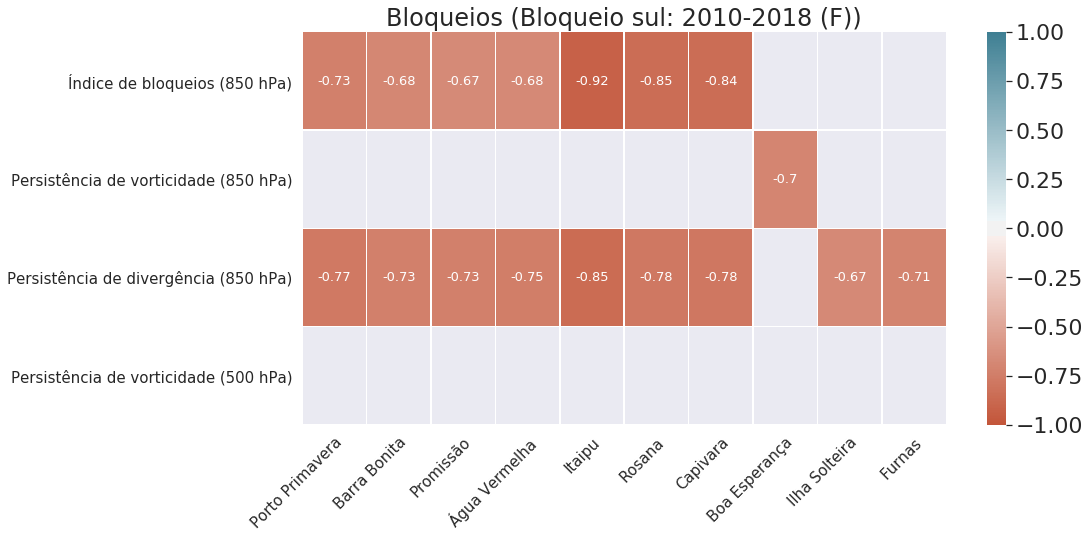

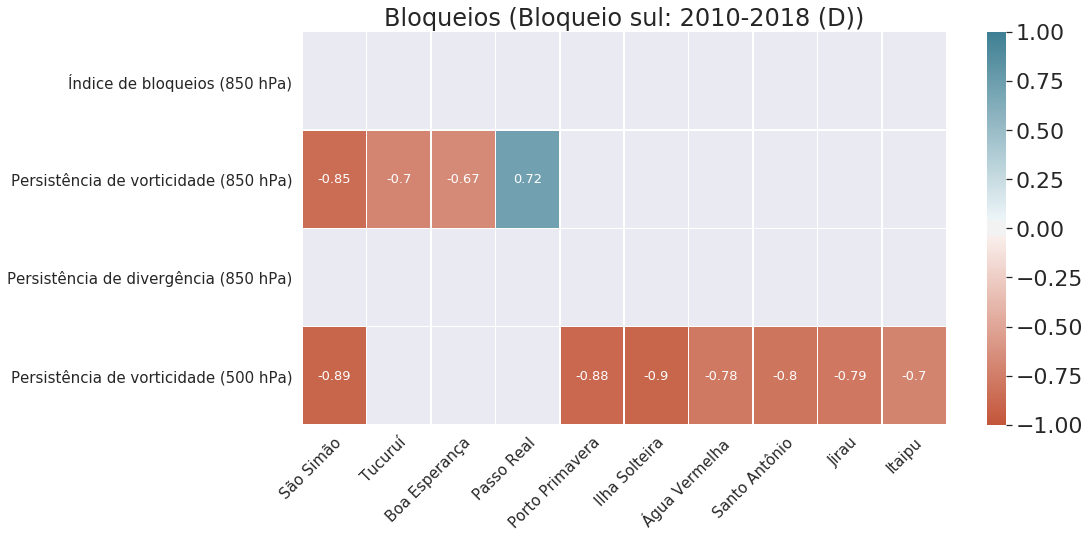

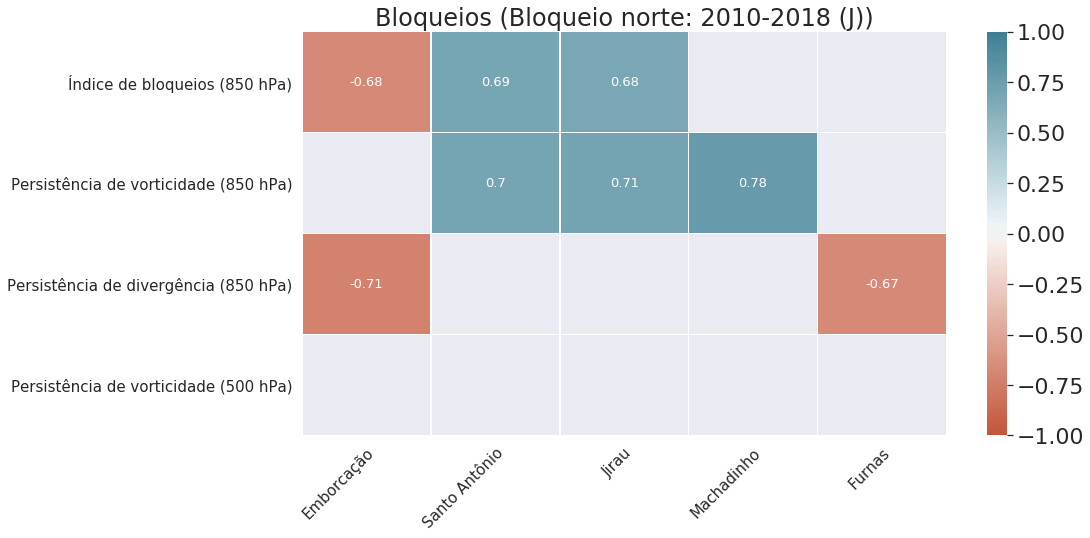

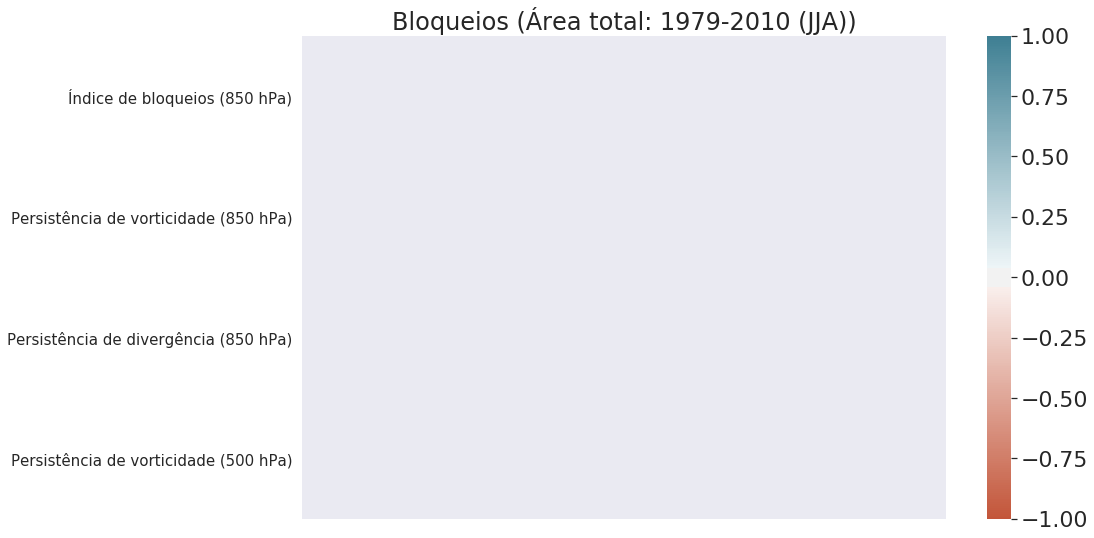

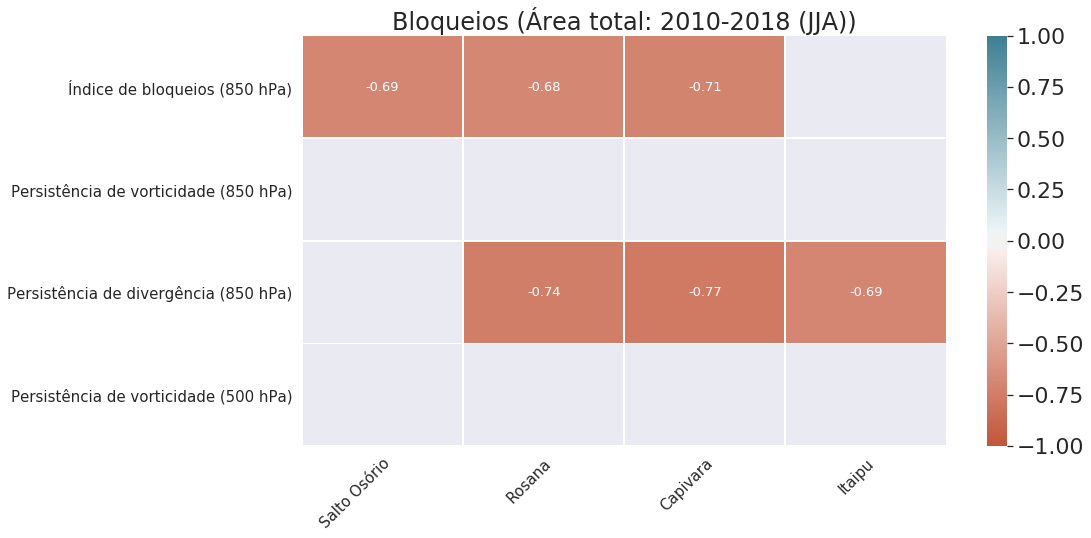

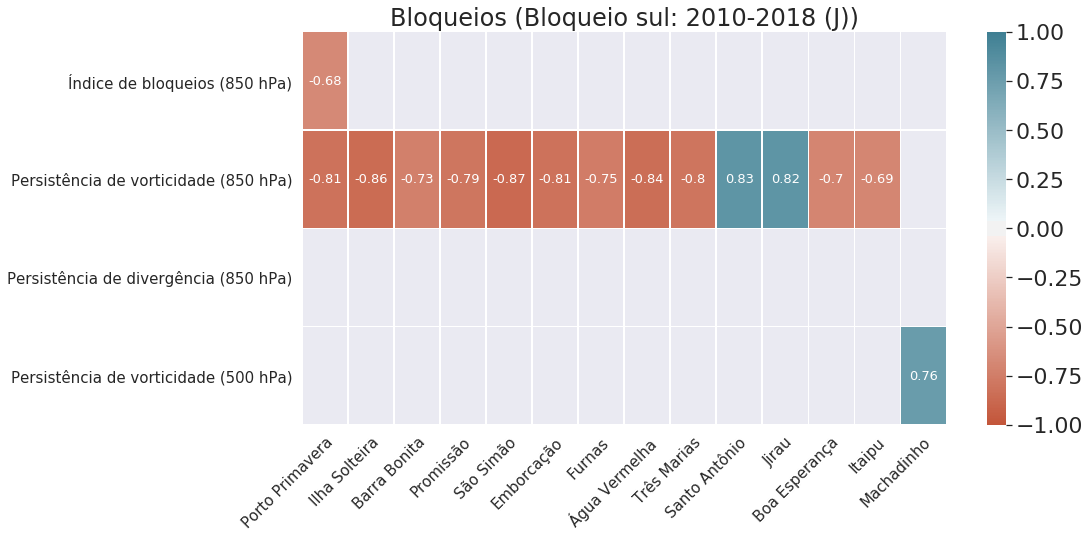

In [359]:
#file = 'corr850-10.0 : -25.0-300.0 : 320.0todasD_DJF_1979-2010.csv'
pattern = 'corr850'
for arquivo in os.listdir():
    try:
        match = re.search(pattern, arquivo).group(0)
        if match:
            #print(arquivo)
            df = pd.read_csv(arquivo, header = 0, index_col=0)
            m_lat = re.search('850(.+?)-300', arquivo).group(1)
            try:
                m_mes = re.search('todas(.+?)_', arquivo).group(1)
            except:
                m_mes = re.search('sul(.+?)_', arquivo).group(1)
                m_mes = m_mes[1:]
            m_periodo = re.search('_(.+?).csv', arquivo).group(1)[4:]
            corrplot(arquivo, m_lat, m_mes, m_periodo)
    except:
        pass


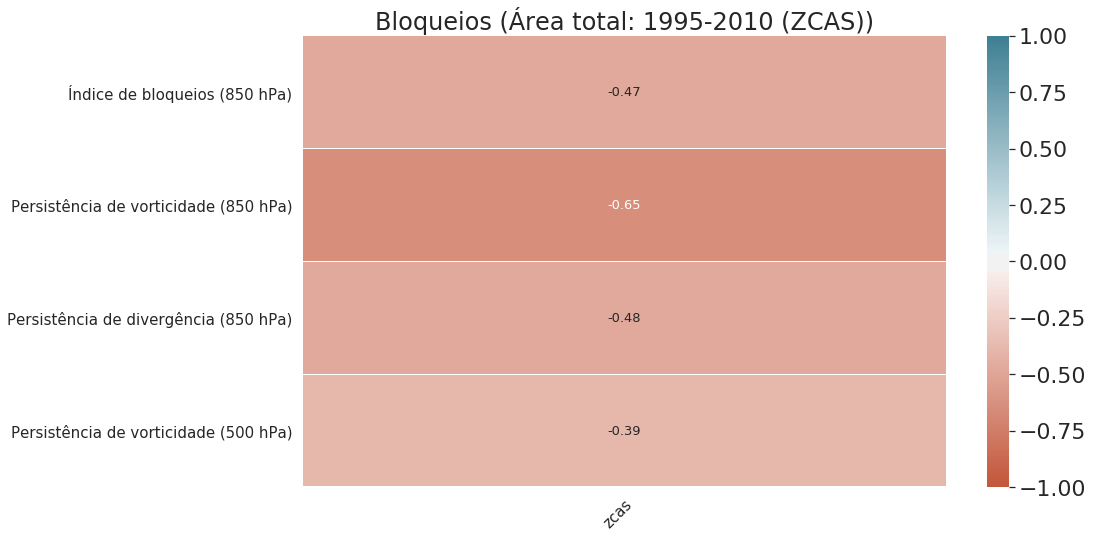

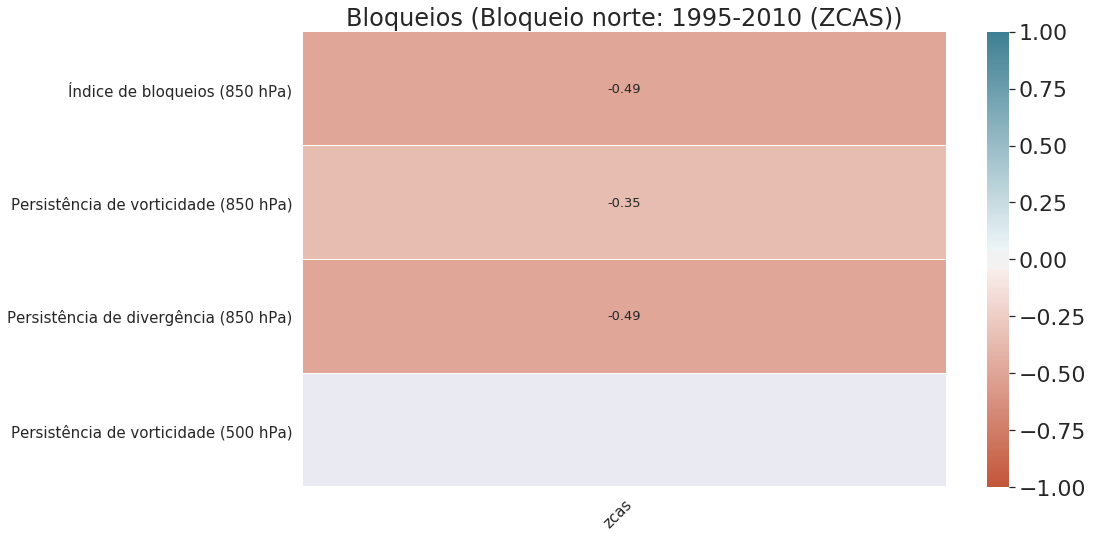

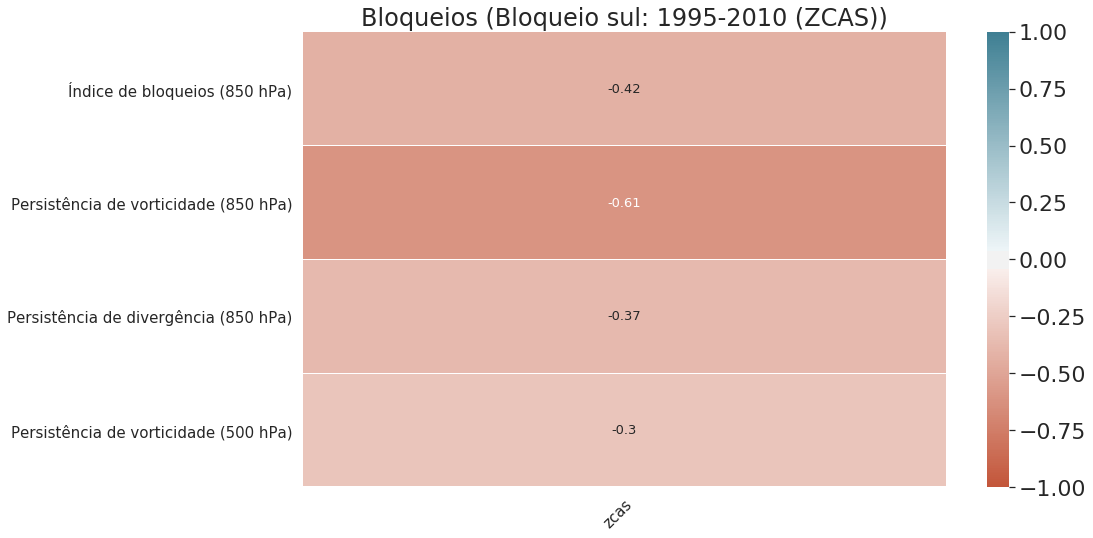

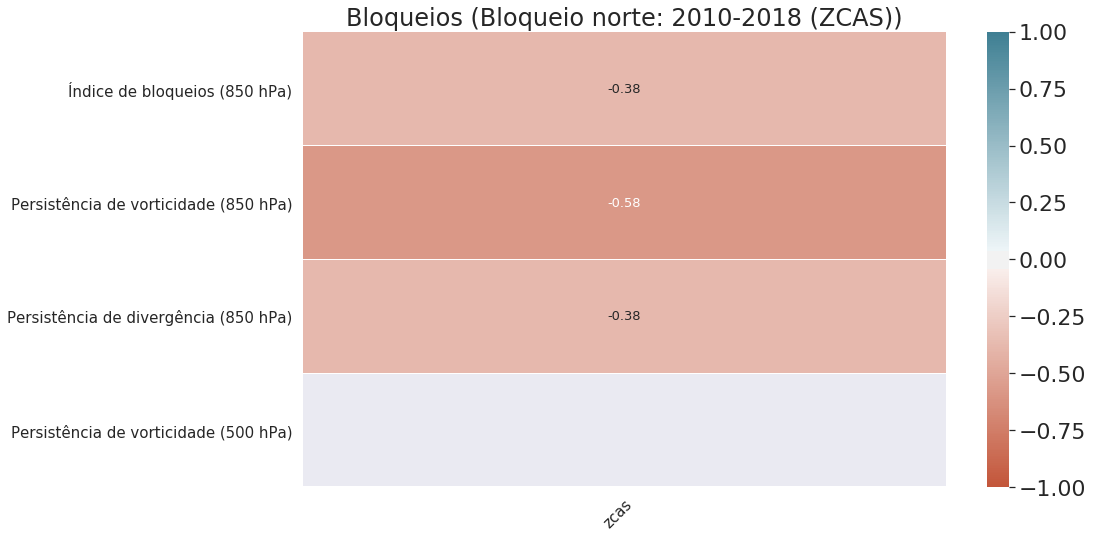

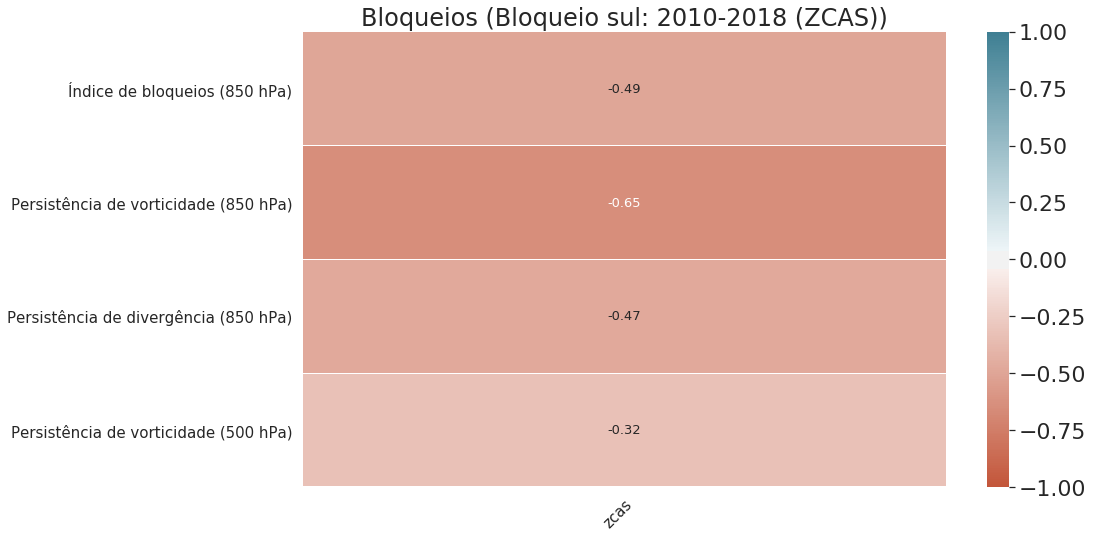

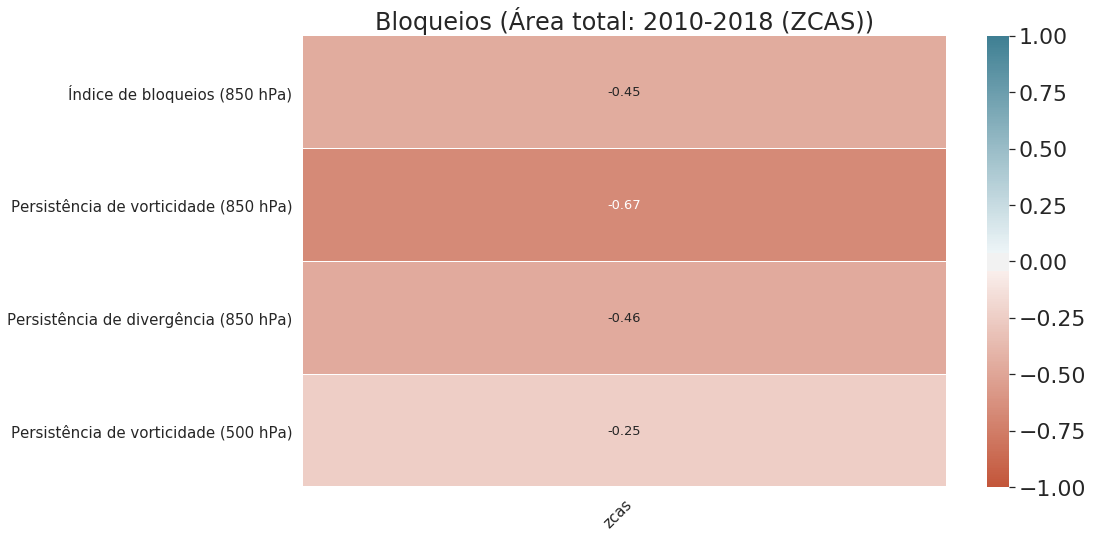

In [363]:
#file = 'corr850-10.0 : -25.0-300.0 : 320.0todasD_DJF_1979-2010.csv'
pattern = 'ZCAS'
for arquivo in os.listdir():
    try:
        match = re.search(pattern, arquivo).group(0)
        if match:
            #print(arquivo)
            df = pd.read_csv(arquivo, header = 0, index_col=0)
            m_lat = re.search('corr(.+?)-300', arquivo).group(1)
            m_periodo = re.search('ZCAS_(.+?).csv', arquivo).group(1)
            corrplot(arquivo, m_lat, 'ZCAS', m_periodo)
    except:
        pass
